In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
!pip install -q --upgrade datasets

In [ ]:
# import datasets
# print(datasets.__version__)

In [3]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

import json
import time
import os
import pandas as pd
import numpy as np
import re
from copy import deepcopy

In [4]:
import torch

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    GenerationConfig,
    TrainingArguments,
    Trainer,
    pipeline
)

from peft import PeftModel, PeftConfig, get_peft_model_state_dict

In [5]:
CHECKPOINTS = "GanjinZero/biobart-large"

### Dataset

In [ ]:
# # MTS
# mts_dialog_dir = "/content/drive/MyDrive/ClinicalNotesGen/Data/clinical_notes/data1_clinical_visit_note_summarization_corpus/data/mts-dialog"
# mts_test_set_1_path = f"{mts_dialog_dir}/MTS_Dataset_Final_200_TestSet_1.csv"
# mts_test_set_2_path = f"{mts_dialog_dir}/MTS_Dataset_Final_200_TestSet_2.csv"
# mts_training_set_path = f"{mts_dialog_dir}/MTS_Dataset_TrainingSet.csv"
# mts_val_set_path = f"{mts_dialog_dir}/MTS_Dataset_ValidationSet.csv"

# mts_training_set_df = pd.read_csv(mts_training_set_path, index_col='ID')
# mts_val_set_df = pd.read_csv(mts_val_set_path, index_col='ID')
# mts_test_set_1_df = pd.read_csv(mts_test_set_1_path, index_col='ID')
# mts_test_set_2_df = pd.read_csv(mts_test_set_2_path, index_col='ID')

In [ ]:
# # ACI-Bench
# aci_bench_dir = "/content/drive/MyDrive/ClinicalNotesGen/Data/clinical_notes/data1_clinical_visit_note_summarization_corpus/data/aci-bench"
# challenge_data_dir = f"{aci_bench_dir}/challenge_data"
# src_experiment_data_dir = f"{aci_bench_dir}/src_experiment_data"

# challenge_data_files = os.listdir(challenge_data_dir)
# challenge_data_dfs = {}
# for file in challenge_data_files:
#     challenge_data_dfs[file] = pd.read_csv(f"{challenge_data_dir}/{file}")

In [6]:
dataset_dir = '/content/drive/MyDrive/ClinicalNotesGen/Data/synthetic_dataset'
file_paths = {
    'train': f'{dataset_dir}/aug_train.parquet',
    'val': f'{dataset_dir}/aug_val.parquet',
    'test': f'{dataset_dir}/aug_test.parquet'
}

train_df = pd.read_parquet(file_paths['train'])
test_df = pd.read_parquet(file_paths['test'])
val_df = pd.read_parquet(file_paths['val'])

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

# Create a DatasetDict
ds = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": val_dataset
})

### Model, Tokenizer

In [7]:
fine_tune_path = '/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM'
model_name = 'bart' # ADJUST
sub_model_name = 'bio_bart' # ADJUST
checkpoints_dir = f"{fine_tune_path}/{model_name}/{sub_model_name}/lora_1" # ADJUST
checkpoints_path = f"{checkpoints_dir}/checkpoints"
final_checkpoints_path = f"{checkpoints_dir}/final_checkpoints"

In [8]:
checkpoints_path = f"{checkpoints_dir}/dialogue-summary-training-2025-06-19_06-03-00/checkpoint-219"

In [9]:
final_checkpoints_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/bart/bio_bart/lora_1/final_checkpoints'

In [10]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### PeftConfig

In [12]:
perf_config = PeftConfig.from_pretrained(final_checkpoints_path)
print("perf_config.base_model_name_or_path: ", perf_config.base_model_name_or_path)
print("perf_coperf_config: ", perf_config)

perf_config.base_model_name_or_path:  GanjinZero/biobart-large
perf_coperf_config:  LoraConfig(task_type='SEQ_2_SEQ_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='GanjinZero/biobart-large', revision=None, inference_mode=True, r=32, target_modules={'k_proj', 'v_proj', 'q_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)


#### Tokenizer

In [13]:
# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(final_checkpoints_path)

#### Base model

In [ ]:
base_model = AutoModelForSeq2SeqLM.from_pretrained(perf_config.base_model_name_or_path, device_map='auto')
print_trainable_parameters(base_model)

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

trainable params: 568699904 || all params: 569748480 || trainable%: 99.81595808733005


In [ ]:
base_model.eval()
print_trainable_parameters(base_model)

trainable params: 568699904 || all params: 569748480 || trainable%: 99.81595808733005


####  FT model

In [14]:
ft_base = AutoModelForSeq2SeqLM.from_pretrained(perf_config.base_model_name_or_path, return_dict=True, device_map='auto')
print_trainable_parameters(ft_base)

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

trainable params: 406291456 || all params: 406291456 || trainable%: 100.0


In [15]:
ft_model = PeftModel.from_pretrained(ft_base, final_checkpoints_path)
print_trainable_parameters(ft_model)

trainable params: 0 || all params: 413369344 || trainable%: 0.0


In [16]:
ft_model.eval()
print_trainable_parameters(ft_model)

trainable params: 0 || all params: 413369344 || trainable%: 0.0


#### Check

In [17]:
print(413369344  - 406291456 )

7077888


In [ ]:
sep = "-" * 90
print(f"{sep}\nTokenizer:")
print(f"Default max input length: {tokenizer.model_max_length}")
print(f"{sep}\nBase model:")
print("max_position_embeddings:", base_model.config.max_position_embeddings)
print(f"Default generation max_new_tokens: {base_model.generation_config.max_new_tokens}")  # often None
print(f"Default generation max_length: {base_model.generation_config.max_length}")
print(f"{sep}\nFT model:")
print("max_position_embeddings:", ft_model.config.max_position_embeddings)
print(f"Default generation max_new_tokens: {ft_model.generation_config.max_new_tokens}")  # often None
print(f"Default generation max_length: {ft_model.generation_config.max_length}")

------------------------------------------------------------------------------------------
Tokenizer:
Default max input length: 512
------------------------------------------------------------------------------------------
Base model:
max_position_embeddings: 512
Default generation max_new_tokens: None
Default generation max_length: 64
------------------------------------------------------------------------------------------
FT model:
max_position_embeddings: 512
Default generation max_new_tokens: None
Default generation max_length: 64


In [ ]:
base_model.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.6,
  "max_length": 64,
  "num_beams": 8,
  "pad_token_id": 0
}

In [19]:
ft_model.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

In [20]:
print(ft_model.peft_config)

{'default': LoraConfig(task_type='SEQ_2_SEQ_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='GanjinZero/biobart-large', revision=None, inference_mode=True, r=32, target_modules={'k_proj', 'v_proj', 'q_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}


# Generate responses

In [21]:
MAX_SOURCE_LEN = 512
MAX_TARGET_LEN = 428

## Testing

In [ ]:
# gen_cfg = GenerationConfig(
#     max_new_tokens=216,
#     # min_length=64,
#     num_beams=4,  # encourages diverse, complete outputs
#     do_sample=False, # deterministic output
#     early_stopping=True,    # helps finalize beam outputs when confident
#     length_penalty=2.0      # higher = prefers longer outputs (default is 1.0)
# )

In [22]:
gen_cfg = deepcopy(ft_model.generation_config)
gen_cfg.max_new_tokens = MAX_TARGET_LEN
gen_cfg.num_beams      = 1
gen_cfg.do_sample      = False
gen_cfg.early_stopping = False

In [23]:
gen_cfg

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_new_tokens": 428,
  "no_repeat_ngram_size": 3,
  "pad_token_id": 1
}

In [24]:
def gen_response(dialogue, note, base_model, ft_model):
    prompt = f"""{dialogue}"""

    # 1. Tokenise input
    inputs = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=MAX_SOURCE_LEN
    ).to(device)

    # 2. Inference
    # Base model
    with torch.no_grad():
        gen_ids = base_model.generate(**inputs, generation_config=gen_cfg)
    output = tokenizer.decode(gen_ids[0], skip_special_tokens=True).strip()

    # Fine-tuned model
    with torch.no_grad():
        gen_ids_2 = ft_model.generate(**inputs, generation_config=gen_cfg)
    output_2 = tokenizer.decode(gen_ids_2[0], skip_special_tokens=True).strip()

    # 3. Debug info
    print(f"Input token length: {inputs['input_ids'].shape[1]}")
    print(f"Reference note tokens: {len(tokenizer(note)['input_ids'])}")

    # 4. Print results
    print(f'{sep}\nINPUT PROMPT:\n{prompt}')
    print(f'{sep}\nREFERENCE SUMMARY:\n{note}')
    # print(f'{sep}\nTOKENIZED OUTPUT:\n{output_ids}')
    print(f'{sep}\nBASE MODEL:\n{output}')
    # print(f'{sep}\nTOKENIZED OUTPUT:\n{output_2_ids}')
    print(f'{sep}\nFINE-TUNED MODEL:\n{output_2}')

In [ ]:
# sample_idx = 0
# sample_dial = mts_training_set_df.iloc[1]['dialogue']
# sample_note = mts_training_set_df.iloc[1]['section_text']
# gen_response(sample_dial, sample_note, base_model, ft_model)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 129
------------------------------------------------------------------------------------------
INPUT PROMPT:
Doctor: How're you feeling today?  
Patient: Terrible. I'm having the worst headache of my life. 
Doctor: I'm so sorry. Well you are only twenty five, so let's hope this is the last of the worst. Let's see how we can best help you. When did it start? 
Patient: Around eleven in the morning. 
Doctor: Today? 
Patient: Um no yesterday. July thirty first. 
Doctor: July thirty first O eight. Got it. Did it come on suddenly? 
Patient: Yeah. 
Doctor: Are you having any symptoms with it, such as blurry vision, light sensitivity, dizziness, lightheadedness, or nausea? 
Patient: I'm having blurry vision and lightheadedness.  I also can't seem to write well. It looks so messy. I am naturally right handed but my writing looks like I am trying with my left. 
Doctor: How would you describe the lightheadedness? 
Patient: Like there are blind spots.

In [ ]:
# sample_idx = 1
# sample_dial = challenge_data_dfs['train.csv'].iloc[0]["dialogue"]
# sample_note = challenge_data_dfs['train.csv'].iloc[0]["note"]
# gen_response(sample_dial, sample_note, base_model, ft_model)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Input token length: 512
Reference note tokens: 720
------------------------------------------------------------------------------------------
INPUT PROMPT:
[doctor] hi , martha . how are you ?
[patient] i'm doing okay . how are you ?
[doctor] i'm doing okay . so , i know the nurse told you about dax . i'd like to tell dax a little bit about you , okay ?
[patient] okay .
[doctor] martha is a 50-year-old female with a past medical history significant for congestive heart failure , depression and hypertension who presents for her annual exam . so , martha , it's been a year since i've seen you . how are you doing ?
[patient] i'm doing well . i've been traveling a lot recently since things have , have gotten a bit lighter . and i got my , my vaccine , so i feel safer about traveling . i've been doing a lot of hiking . uh , went to washington last weekend to hike in northern cascades, like around the mount baker area .
[doctor] nice . that's great . i'm glad to hear that you're staying acti

In [25]:
sample_idx = 0
sample_dial = ds["train"][sample_idx]["augmented_dialogue"]
sample_note = ds["train"][sample_idx]["soap_note"]
gen_response(sample_dial, sample_note, base_model, ft_model)

NameError: name 'base_model' is not defined

In [ ]:
sample_idx = 1
sample_dial = ds["test"][sample_idx]["augmented_dialogue"]
sample_note = ds["test"][sample_idx]["soap_note"]
gen_response(sample_dial, sample_note, base_model, ft_model)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 222
------------------------------------------------------------------------------------------
INPUT PROMPT:
Doctor: Hello, I understand that you're a 7-year-old boy with congenital bilateral sensorineural deafness, and you've had a failed right cochlear implant. Is that correct?
Patient: Yes, doctor.
Doctor: We recently conducted a Magnetic Resonance Imaging (MRI) before transferring you to the operating theatre for an ABI insertion. During the MRI, your airway was secured with a size 5.5 mm internal-diameter uncuffed ETT. Did you experience any discomfort during the MRI?
Patient: No, it was okay.
Doctor: Great. Now, during the surgery, we will be performing intraoperative neurophysiology monitoring, which includes brainstem auditory sensory evoked potentials, brainstem mapping of CN IX, X, XI, XII and their motor nuclei, and corticobulbar tract motor-evoked potential (MEP). This will help us monitor your nerves during the procedure.
Pati

## Gen 50 responses

In [26]:
def check_length(text):
    prompt = f"""{text}"""

    # tokenize prompt
    input = tokenizer(
        prompt,
        return_tensors="pt",
    )
    print(f"Input token length: {input['input_ids'].shape[1]}")

In [27]:
def get_response(dialogue, note, ft_model):
    prompt = f"""{dialogue}"""

    # 1. Tokenise input
    inputs = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=MAX_SOURCE_LEN
    ).to(device)

    # 2. Inference: Fine-tuned model
    with torch.no_grad():
        gen_ids = ft_model.generate(**inputs, generation_config=gen_cfg)
    output = tokenizer.decode(gen_ids[0], skip_special_tokens=True).strip()

    # 3. Debug info
    print(f"Input token length: {inputs['input_ids'].shape[1]}")
    print(f"Reference note tokens: {len(tokenizer(note)['input_ids'])}")

    return output

### MTS-Dialog (short version)

In [ ]:
mts_gens = []

for i in range(50):
    print(f"Sample {i}:")
    dialogue = mts_training_set_df.iloc[i]['dialogue']
    note = mts_training_set_df.iloc[i]['section_text']

    output = get_response(dialogue, note, ft_model)

    mts_gens.append({
        'dialogue': dialogue,
        'reference_note': note,
        'fine_tuned_model_output': output
    })

mts_gens_df = pd.DataFrame(mts_gens)
mts_gens_df.to_csv(f"{checkpoints_dir}/mts_50.csv", index=False)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Sample 0:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 85
Sample 1:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 129
Sample 2:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 58
Sample 3:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 33
Sample 4:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 6
Sample 5:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 3
Sample 6:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 98
Sample 7:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 6
Sample 8:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 126
Sample 9:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 29
Sample 10:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 53
Sample 11:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 487
Sample 12:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 3
Sample 13:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 16
Sample 14:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 99
Sample 15:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 7
Sample 16:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 138
Sample 17:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 8
Sample 18:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 25
Sample 19:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 3
Sample 20:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 18
Sample 21:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 22
Sample 22:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 39
Sample 23:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 5
Sample 24:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 35
Sample 25:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 12
Sample 26:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 5
Sample 27:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 4
Sample 28:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 166
Sample 29:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 5
Sample 30:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 13
Sample 31:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 62
Sample 32:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 7
Sample 33:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 126
Sample 34:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 70
Sample 35:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 27
Sample 36:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 137
Sample 37:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 8
Sample 38:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 186
Sample 39:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 4
Sample 40:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 100
Sample 41:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 22
Sample 42:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 4
Sample 43:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 4
Sample 44:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 129
Sample 45:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 4
Sample 46:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 13
Sample 47:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 76
Sample 48:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 42
Sample 49:
Input token length: 512
Reference note tokens: 19


In [ ]:
mts_gens_df

,dialogue,reference_note,fine_tuned_model_output
0,Doctor: What brings you back into the clinic t...,The patient is a 76-year-old white female who ...,"S: Patient, a seventy six-year-old white femal..."
1,Doctor: How're you feeling today? \nPatient: ...,The patient is a 25-year-old right-handed Cauc...,"S: The patient, a twenty-five-year-old female,..."
2,"Doctor: Hello, miss. What is the reason for yo...","This is a 22-year-old female, who presented to...","S: The patient, a twenty two year old female, ..."
3,Doctor: Are you taking any over the counter me...,Prescribed medications were Salmeterol inhaler...,S: Patient reports no over-the-counter medicin...
4,"Doctor: Hi, how are you? \nPatient: I burned m...","Burn, right arm.",S: Patient reports burning hand. Patient says ...
5,Doctor: How's your asthma since you started us...,Asthma.,S: The patient reports improvement in asthma s...
6,"Doctor: Do you smoke? \nPatient: No, I quit be...","The patient denies high blood pressure, diabet...","S: Patient is a 30-year-old female, who has a ..."
7,Doctor: Any know drug allergies? \nPatient: No.,No known drug allergies.,S: Patient is a male with a history of asthma ...
8,"Doctor: Hi there, sir! How are you today? \nPa...",His mother died of complications from heart di...,"S: The patient, a male, reports a family histo..."
9,Doctor: Can you tell me about any diseases tha...,His brothers had prostate cancer. Father had ...,S: Patient reports a family history of prostat...


### ACI-Bench

In [ ]:
aci_gens = []

for i in range(50):
    print(f"Sample {i}:")
    dialogue = challenge_data_dfs['train.csv'].iloc[i]["dialogue"]
    note = challenge_data_dfs['train.csv'].iloc[i]["note"]

    output = get_response(dialogue, note, ft_model)

    aci_gens.append({
        'dialogue': dialogue,
        'reference_note': note,
        'fine_tuned_model_output': output
    })

aci_gens_df = pd.DataFrame(aci_gens)
aci_gens_df.to_csv(f"{checkpoints_dir}/aci_50.csv", index=False)
print(f"Saved to: {checkpoints_dir}/aci_50.csv")

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Sample 0:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 720
Sample 1:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 690
Sample 2:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 679
Sample 3:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 653
Sample 4:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 193
Sample 5:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 720
Sample 6:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 574
Sample 7:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 723
Sample 8:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 539
Sample 9:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 466
Sample 10:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 476
Sample 11:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 629
Sample 12:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 454
Sample 13:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 510
Sample 14:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 505
Sample 15:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 645
Sample 16:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 204
Sample 17:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 253
Sample 18:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 237
Sample 19:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 494
Sample 20:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 694
Sample 21:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 1123
Sample 22:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 571
Sample 23:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 273
Sample 24:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 783
Sample 25:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 608
Sample 26:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 762
Sample 27:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 802
Sample 28:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 663
Sample 29:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 482
Sample 30:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 752
Sample 31:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 839
Sample 32:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 380
Sample 33:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 498
Sample 34:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 429
Sample 35:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 465
Sample 36:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 462
Sample 37:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 503
Sample 38:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 399
Sample 39:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 443
Sample 40:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 616
Sample 41:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 583
Sample 42:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 620
Sample 43:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 367
Sample 44:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 401
Sample 45:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 442
Sample 46:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 465
Sample 47:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 586
Sample 48:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 517
Sample 49:
Input token length: 512
Reference note tokens: 455
Saved to: /content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/pegasus/pegasus_xsum/lora_1/aci_soap_50.csv


### Modified SOAP

- train SOAP

In [ ]:
train_soap_gens = []

for i in range(50):
    print(f"Sample {i}:")
    dialogue = ds["train"][i]["augmented_dialogue"]
    note = ds["train"][i]["soap_note"]

    output = get_response(dialogue, note, ft_model)

    train_soap_gens.append({
        'dialogue': dialogue,
        'reference_note': note,
        'fine_tuned_model_output': output
    })

train_soap_gens_df = pd.DataFrame(train_soap_gens)
train_soap_gens_df.to_csv(f"{checkpoints_dir}/train_soap_50.csv", index=False)
print(f"Saved to: {checkpoints_dir}/train_soap_50.csv")

In [ ]:
train_soap_gens_df

- test SOAP

In [ ]:
checkpoints_dir

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/pegasus/pegasus_pubmed/lora_1'

In [28]:
test_soap_gens = []

for i in range(50):
    print(f"Sample {i}:")
    dialogue = ds["test"][i]["augmented_dialogue"]
    note = ds["test"][i]["soap_note"]

    output = get_response(dialogue, note, ft_model)

    test_soap_gens.append({
        'dialogue': dialogue,
        'reference_note': note,
        'fine_tuned_model_output': output
    })

test_soap_gens_df = pd.DataFrame(test_soap_gens)
test_soap_gens_df.to_csv(f"{checkpoints_dir}/test_soap_50.csv", index=False)
print(f"Saved to: {checkpoints_dir}/test_soap_50.csv")

`generation_config` default values have been modified to match model-specific defaults: {'early_stopping': True, 'num_beams': 4}. If this is not desired, please set these values explicitly.


Sample 0:
Input token length: 512
Reference note tokens: 505
Sample 1:
Input token length: 512
Reference note tokens: 257
Sample 2:
Input token length: 512
Reference note tokens: 411
Sample 3:
Input token length: 512
Reference note tokens: 345
Sample 4:
Input token length: 512
Reference note tokens: 378
Sample 5:
Input token length: 512
Reference note tokens: 371
Sample 6:
Input token length: 512
Reference note tokens: 376
Sample 7:
Input token length: 512
Reference note tokens: 349
Sample 8:
Input token length: 512
Reference note tokens: 391
Sample 9:
Input token length: 512
Reference note tokens: 381
Sample 10:
Input token length: 512
Reference note tokens: 383
Sample 11:
Input token length: 512
Reference note tokens: 468
Sample 12:
Input token length: 512
Reference note tokens: 372
Sample 13:
Input token length: 512
Reference note tokens: 281
Sample 14:
Input token length: 512
Reference note tokens: 449
Sample 15:
Input token length: 512
Reference note tokens: 317
Sample 16:


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


Input token length: 512
Reference note tokens: 528
Sample 17:
Input token length: 512
Reference note tokens: 395
Sample 18:
Input token length: 512
Reference note tokens: 306
Sample 19:
Input token length: 512
Reference note tokens: 226
Sample 20:
Input token length: 512
Reference note tokens: 375
Sample 21:
Input token length: 512
Reference note tokens: 443
Sample 22:
Input token length: 512
Reference note tokens: 381
Sample 23:
Input token length: 512
Reference note tokens: 324
Sample 24:
Input token length: 512
Reference note tokens: 370
Sample 25:
Input token length: 512
Reference note tokens: 471
Sample 26:
Input token length: 512
Reference note tokens: 266
Sample 27:
Input token length: 512
Reference note tokens: 226
Sample 28:
Input token length: 512
Reference note tokens: 281
Sample 29:
Input token length: 512
Reference note tokens: 371
Sample 30:
Input token length: 512
Reference note tokens: 488
Sample 31:
Input token length: 512
Reference note tokens: 418
Sample 32:
Input to

In [29]:
test_soap_gens_df

,dialogue,reference_note,fine_tuned_model_output
0,"Doctor: Hello, can you please tell me about yo...","S: The patient, a flooring installer with no s...","S: The patient, a flooring installer, reports ..."
1,"Doctor: Hello, I understand that you're a 7-ye...",S: The patient is a 7-year-old boy with congen...,"S: The patient, a 7-year-old boy with congenit..."
2,"Doctor: Hello, we've received your results fro...",S: The patient reported undergoing an ultrasou...,S: The patient reports a single thyroid nodule...
3,"Doctor: Hello, can you tell me what brought yo...","S: The patient reports a progressive headache,...","S: The patient reports a progressive headache,..."
4,"Doctor: Hello, I uh understand that you have h...","S: The patient, a post-liver transplant recipi...","S: The patient, a liver transplant recipient w..."
5,"Doctor: Hello, how can I help you today?\nPati...","S: The patient, a non-smoker and engineer, rep...","S: The patient, a non-smoker, reports experien..."
6,"Doctor: Hi there, I see you've presented with ...",S: The patient presented with body weight loss...,S: The patient presents with body weight loss....
7,"Doctor: Hello, I heard you have a 6-month hist...",S: The patient reports a 6-month history of sw...,S: The patient reports a 6-month history of sw...
8,"Doctor: Hi there, can you please tell me about...","S: The patient, a male with a history of prost...","S: The patient, a prostate cancer patient, rep..."
9,"Doctor: Hello, how can I I help you today?\nPa...",S: The patient is a 76-year-old woman presenti...,Sixty-six-year-old female with hypertension an...


In [ ]:
test_soap_gens_2 = []

for i in range(50, 100):
    print(f"Sample {i}:")
    dialogue = ds["test"][i]["augmented_dialogue"]
    note = ds["test"][i]["soap_note"]

    output = get_response(dialogue, note, ft_model)

    test_soap_gens_2.append({
        'dialogue': dialogue,
        'reference_note': note,
        'fine_tuned_model_output': output
    })

test_soap_gens_df_2 = pd.DataFrame(test_soap_gens_2)
test_soap_gens_df_2.to_csv(f"{checkpoints_dir}/test_soap_50_100.csv", index=False)
print(f"Saved to: {checkpoints_dir}/test_soap_50_100.csv")

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Sample 50:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 211
Sample 51:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 313
Sample 52:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 317
Sample 53:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 187
Sample 54:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 323
Sample 55:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 365
Sample 56:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 316
Sample 57:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 352
Sample 58:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 292
Sample 59:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 434
Sample 60:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 398
Sample 61:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 385
Sample 62:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 320
Sample 63:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 223
Sample 64:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 267
Sample 65:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 326
Sample 66:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 272
Sample 67:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 393
Sample 68:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 474
Sample 69:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 289
Sample 70:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 294
Sample 71:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 418
Sample 72:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 358
Sample 73:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 286
Sample 74:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 313
Sample 75:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 463
Sample 76:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 367
Sample 77:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 338
Sample 78:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 349
Sample 79:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 337
Sample 80:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 370
Sample 81:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 390
Sample 82:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 420
Sample 83:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 384
Sample 84:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 213
Sample 85:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 284
Sample 86:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 339
Sample 87:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 230
Sample 88:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 241
Sample 89:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 380
Sample 90:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 331
Sample 91:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 310
Sample 92:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 404
Sample 93:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 351
Sample 94:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 350
Sample 95:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 311
Sample 96:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 282
Sample 97:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 388
Sample 98:


The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Input token length: 512
Reference note tokens: 338
Sample 99:
Input token length: 512
Reference note tokens: 365
Saved to: /content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/pegasus/pegasus_xsum/lora_1/test_soap_50_100.csv


In [ ]:
test_soap_gens_df_2

,dialogue,reference_note,fine_tuned_model_output
0,"Doctor: Hello, what brings you in today?\nPati...",S: The patient reports severe pain in the lowe...,S: The patient reports a golf ball incident in...
1,"Doctor: Hello, how can I help you today?\nPati...",S: The patient is a 65-year-old male presentin...,S: The patient is a 65-year-old male with a hi...
2,"Doctor: Hello, I understand that you have a hi...",S: Patient reports a one-week history of fever...,"S: The patient, a breast abscess patient with ..."
3,"Doctor: Hello, how can I help you today?\nPati...",S: The patient reports a 4-month history of di...,S: The patient reports difficulty swallowing f...
4,"Doctor: Hello, I heard you were referred to th...","S: The patient, a 10-year smoker, presents wit...","S: The patient, a male office worker, reports ..."
5,"Doctor: Hello, how can I help you today?\nPati...",S: The patient is a 41-year-old male farmer wi...,"S: The patient, a 41-year-old male farmer, rep..."
6,"Doctor: Hi there, I understand you've been ref...","S: The patient, initially diagnosed at age 14 ...",S: The patient reports abdominal bloating and ...
7,"Doctor: Hi, how can I help you today?\nPatient...","S: The patient, who has experienced mobility a...","S: The patient, a male with a history of sever..."
8,"Doctor: Hello, how can I help you today?\nPati...",S: The patient reports a high voltage electric...,S: The patient reports a high voltage electric...
9,"Doctor: Hello there, I see you have a history ...","S: The patient, with a history of hypertension...","S: The patient, a hypertension and well-contro..."


### Check loss

In [ ]:
checkpoints_path

'/content/drive/MyDrive/ClinicalNotesGen/Summarization/3_Fine_Tune_LLM/pegasus/pegasus_pubmed/lora_1/checkpoints/dialogue-summary-training-2025-06-18_21-25-29/checkpoint-870'

In [ ]:
# Load trainer_state.json
trainer_state_path = os.path.join(checkpoints_path, "trainer_state.json")
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    # Print training and evaluation metrics
    for log in trainer_state["log_history"]:
        step = log.get("step", "N/A")
        train_loss = log.get("loss", "N/A")
        eval_loss = log.get("eval_loss", "N/A")
        print(f"Step {step}: Train Loss = {train_loss}, Eval Loss = {eval_loss}")
else:
    print("No trainer_state.json found. Check if training completed successfully.")

Step 100: Train Loss = 5.351, Eval Loss = N/A
Step 200: Train Loss = 4.0667, Eval Loss = N/A
Step 300: Train Loss = 3.5344, Eval Loss = N/A
Step 400: Train Loss = 3.2548, Eval Loss = N/A
Step 500: Train Loss = 3.1728, Eval Loss = N/A
Step 600: Train Loss = 3.1109, Eval Loss = N/A
Step 700: Train Loss = 3.1114, Eval Loss = N/A
Step 800: Train Loss = 3.0796, Eval Loss = N/A


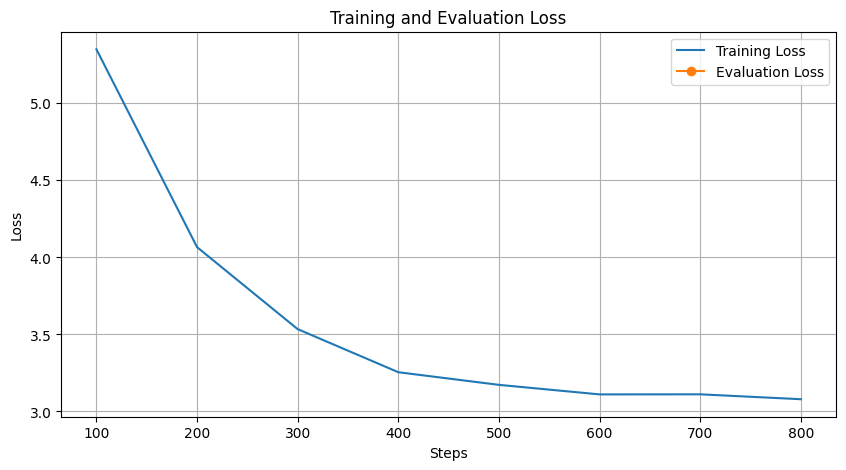

In [ ]:
import matplotlib.pyplot as plt

steps = []
train_losses = []
eval_losses = []
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    for log in trainer_state["log_history"]:
        step = log.get("step")
        if "loss" in log:
            steps.append(step)
            train_losses.append(log["loss"])
            eval_losses.append(None)
        if "eval_loss" in log:
            steps.append(step)
            eval_losses[-1] = log["eval_loss"]

    plt.figure(figsize=(10, 5))
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
    plt.plot([s for s, e in zip(steps, eval_losses) if e is not None],
             [e for e in eval_losses if e is not None],
             label="Evaluation Loss", marker="o")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found.")

In [ ]:
import matplotlib.pyplot as plt

steps = []
train_losses = []
eval_losses = []
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    for log in trainer_state["log_history"]:
        step = log.get("step")
        if "loss" in log:
            steps.append(step)
            train_losses.append(log["loss"])
            eval_losses.append(None)

    plt.figure(figsize=(10, 5))
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
    plt.plot([s for s, e in zip(steps, eval_losses) if e is not None],
             [e for e in eval_losses if e is not None],
             label="Evaluation Loss", marker="o")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found.")

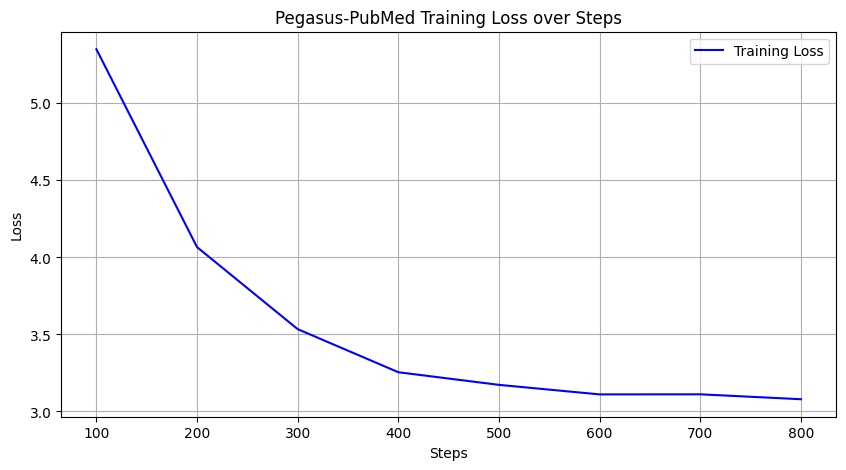

In [ ]:
steps = []
train_losses = []

if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    for log in trainer_state["log_history"]:
        step = log.get("step")
        if "loss" in log:
            steps.append(step)
            train_losses.append(log["loss"])

    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_losses, label="Training Loss", color='blue')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Pegasus-PubMed Training Loss over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found.")